In [48]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i


Epoch # 1------------------------------------



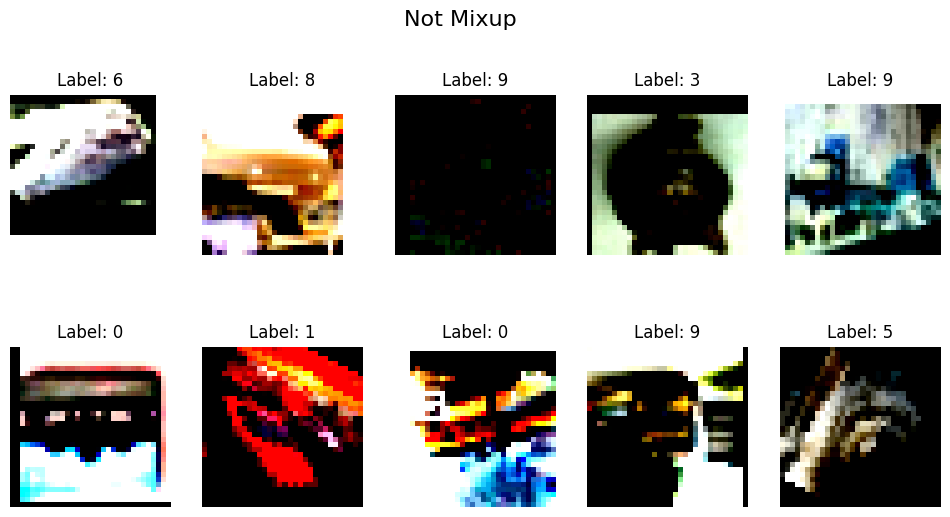


Epoch # 2------------------------------------


Epoch # 3------------------------------------


Epoch # 4------------------------------------


Epoch # 5------------------------------------



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i


Epoch # 1------------------------------------



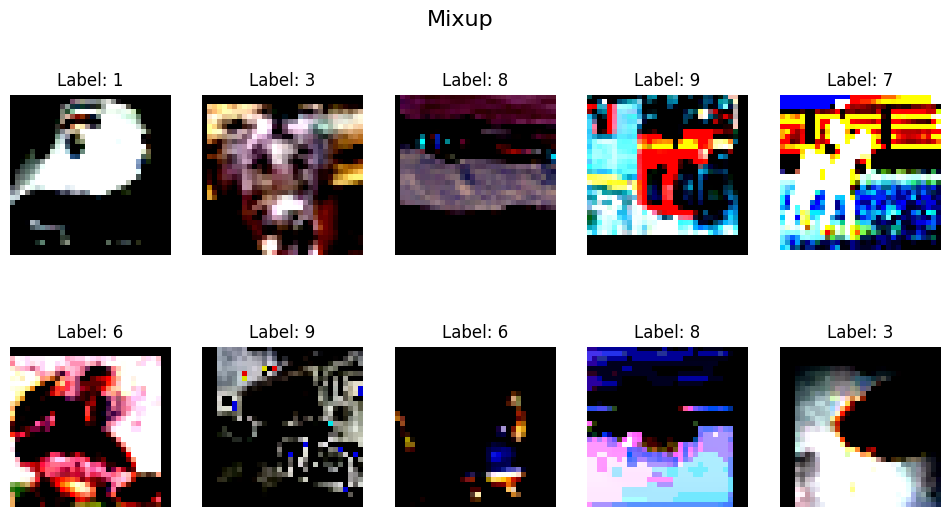


Epoch # 2------------------------------------


Epoch # 3------------------------------------


Epoch # 4------------------------------------


Epoch # 5------------------------------------



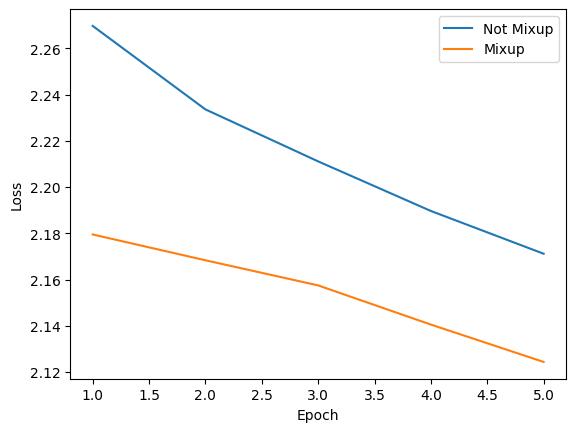

In [49]:
# data를 Mixup해주는 함수 정의

def MixUp(x, y, lam):
    batch_size = x.size(0)
    mixup_index = torch.randperm(batch_size)
    
    mixup_inputs = lam * x + (1 - lam) * x[mixup_index, :] # x[mixup_index, :]: image의 순서가 섞인 것

    labels, mixup_labels = y, y[mixup_index]
    
    return mixup_inputs, labels, mixup_labels, lam

# model 정의

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__() 
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(16 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

# Mixup에서의 loss function 정의

def MixUpLoss(criterion, pred, labels, mixup_labels, lam):
    return lam * criterion(pred, labels) + (1 - lam) * criterion(pred, mixup_labels)

# image 시각화 함수 정의

def plot_images(images, labels, title): 
    fig, axes = plt.subplots(2, 5, figsize=(12,6))
    
    fig.suptitle(title, fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        image = images[i]
    
        image = np.transpose(image, (1, 2, 0)) # imshow()하기 위해, (channel, h, w) -> (h, w, channel)로 transpose
        
        ax.imshow(image, cmap='gray')
        
        ax.set_title(f"Label: {labels[i]}")
        
        ax.axis('off')
        
    plt.show()

# data set, data loader 준비

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.AutoAugment(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.3,0.3,0.3))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform = train_transform, download=False)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# model, criterion, optimizer, hyperparameter 준비

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MyModel()

criterion = nn.CrossEntropyLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001)

num_epochs = 5

# Mixup 없이 training

losses_list = []

temp = 0

for epoch in range(num_epochs):
    print(f"\nEpoch # {epoch + 1}------------------------------------\n")
    model.train()
    
    losses = 0.0
    
    for x, y in train_dataloader:
        ori_inputs, ori_labels = x, y
        
        if temp == 0:
            plot_images(ori_inputs, ori_labels, 'Not Mixup')
            
            temp = 1
        
        optimizer.zero_grad()
        
        ori_outputs = model(ori_inputs)
        
        loss = criterion(ori_outputs, ori_labels)
        
        loss.backward()
        
        optimizer.step()
        
        losses += loss.item()
        
    losses_list.append(losses / len(train_dataloader))
    
# Mixup하여 Training

mixup_losses_list = []

temp2 = 0
    
for epoch in range(num_epochs):
    print(f"\nEpoch # {epoch + 1}------------------------------------\n")
    model.train()
    
    mixup_losses = 0.0
    
    for x, y in train_dataloader:
        ori_inputs, ori_labels = x, y
        
        alpha = 0.2
        lam = np.random.beta(alpha, alpha)
        
        mixup_inputs, _, mixup_labels, _ = MixUp(x, y, lam)
        
        if temp2 == 0:
            plot_images(mixup_inputs, mixup_labels, 'Mixup')
            
            temp2 = 1
            
        optimizer.zero_grad()
        
        mixup_outputs = model(mixup_inputs)
        
        mixup_loss = MixUpLoss(criterion, mixup_outputs, ori_labels, mixup_labels, lam)
        
        mixup_loss.backward()
        
        optimizer.step()
        
        mixup_losses += mixup_loss.item()

    mixup_losses_list.append(mixup_losses / len(train_dataloader))
    
# Loss 비교

epoch_range = range(1, num_epochs + 1)

plt.plot(epoch_range, losses_list, label='Not Mixup')
plt.plot(epoch_range, mixup_losses_list, label='Mixup')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()